# 🧠 Automated Brain Tumor Classification using MRI
# Author: Lincoln | Date: 2025-06-25
# GitHub Repo: https://github.com/lincolndibler/BrainTumorClassification
# Dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# **1.) Imports and Paths**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import os
import sys
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_pre
from sklearn.utils import class_weight


In [3]:
sys.path.append('/content/drive/MyDrive/BrainTumorClassification')

In [4]:
from utils import create_generators
from utils import count_images_per_class, plot_random_images_per_class, create_generators
from evaluation import ModelEvaluator, gradcam_samples_by_class, show_misclassified_images
from utils import get_augmented_train_generator
from models import finetune_mobilenet_model
from models import train_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BASE_DIR = '/content/drive/MyDrive/BrainTumorClassification'
TRAIN_DIR = f'{BASE_DIR}/data/Training'
TEST_DIR = f'{BASE_DIR}/data/Testing'

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_pre

_, _, test_gen_mobile = create_generators(
    TRAIN_DIR, TEST_DIR, img_size=(224,224), preprocessing=mobilenet_pre, shuffle_test=False)

_, _, test_gen_resnet = create_generators(
    TRAIN_DIR, TEST_DIR, img_size=(224,224), preprocessing=resnet_pre, shuffle_test=False)

_, _, test_gen_effnet = create_generators(
    TRAIN_DIR, TEST_DIR, img_size=(240,240), preprocessing=effnet_pre, shuffle_test=False)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## **2.) Model Configuration**

In [7]:
from tensorflow.keras.models import load_model

# Load each model
mobilenet_model = load_model(f'{BASE_DIR}/saved_models/mobilenet_model.keras')
resnet_model = load_model(f'{BASE_DIR}/saved_models/resnet_model.keras')
effnet_model = load_model(f'{BASE_DIR}/saved_models/effnet_model.keras')


# **3.) Model Evaluation**

In [8]:
evaluator_mobilenet = ModelEvaluator(
    model=mobilenet_model,
    #history=history_mobilenet,
    test_gen=test_gen_mobile,
    class_names=list(test_gen_mobile.class_indices.keys()),
    input_size=(224, 224),
    preprocess_fn=mobilenet_pre,
    last_conv_layer='Conv_1'
)

evaluator_resnet = ModelEvaluator(
    model=resnet_model,
    #history=history_resnet,
    test_gen=test_gen_resnet,
    class_names=list(test_gen_resnet.class_indices.keys()),
    input_size=(224, 224),
    preprocess_fn=resnet_pre,
    last_conv_layer='conv5_block3_out'
)

evaluator_effnet = ModelEvaluator(
    model=effnet_model,
    #history=history_effnet,
    test_gen=test_gen_effnet,
    class_names=list(test_gen_effnet.class_indices.keys()),
    input_size=(240, 240),
    preprocess_fn=effnet_pre,
    last_conv_layer='top_conv'
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[Warning] Failed to extract x_test: name 'extract_data_from_generator' is not defined
[Warning] Failed to extract x_test: name 'extract_data_from_generator' is not defined
[Warning] Failed to extract x_test: name 'extract_data_from_generator' is not defined


# **5.) Final Comparison Tables**

📊 MobileNetV2


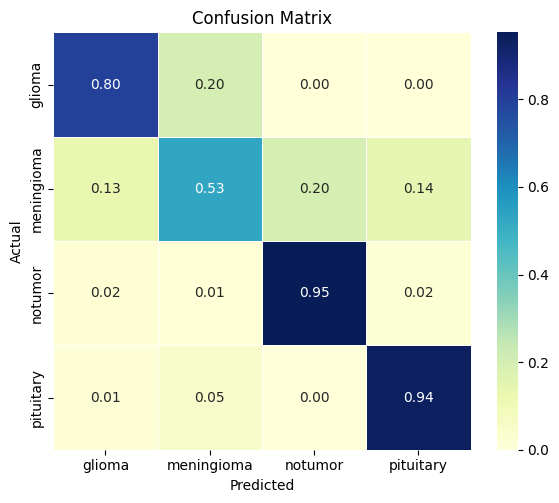

              precision    recall  f1-score   support

      glioma       0.82      0.80      0.81       300
  meningioma       0.68      0.53      0.59       306
     notumor       0.86      0.95      0.91       405
   pituitary       0.84      0.94      0.89       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.80      1311
weighted avg       0.81      0.81      0.81      1311



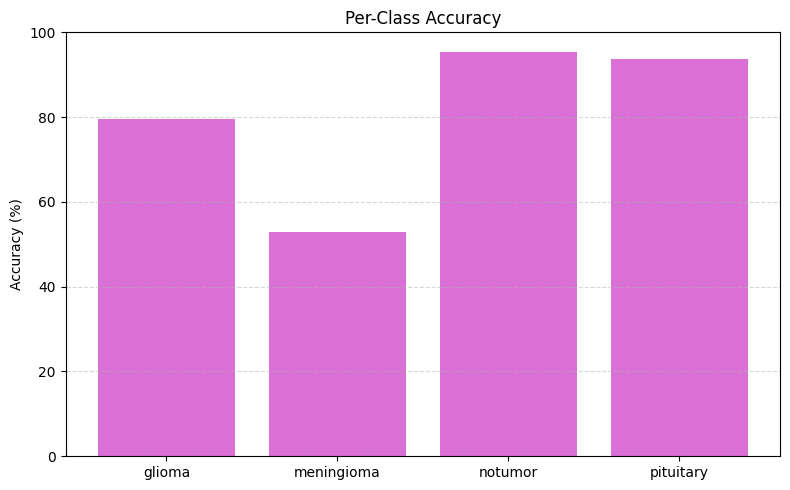

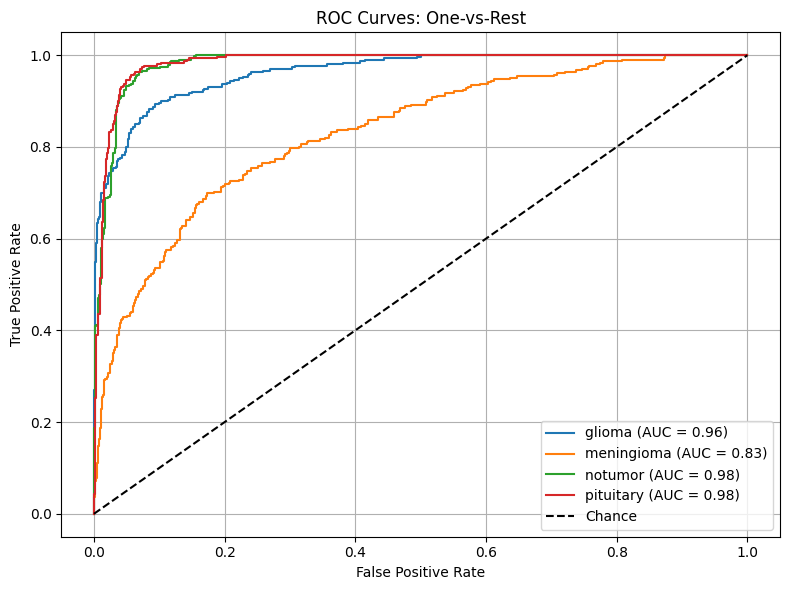

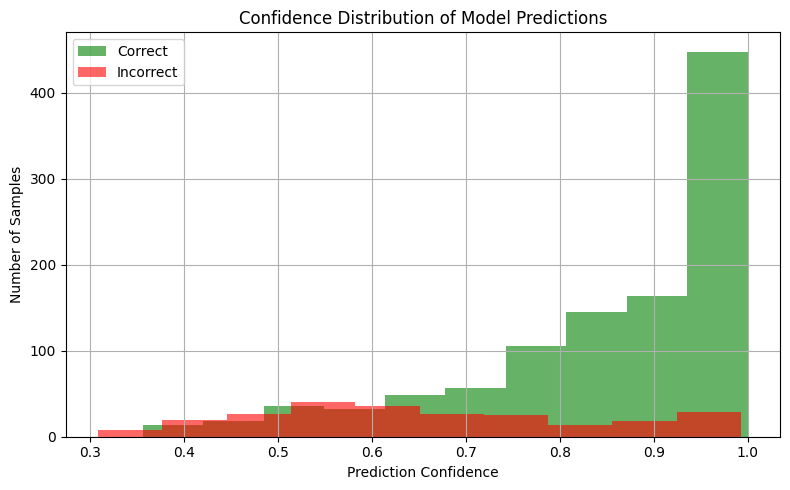

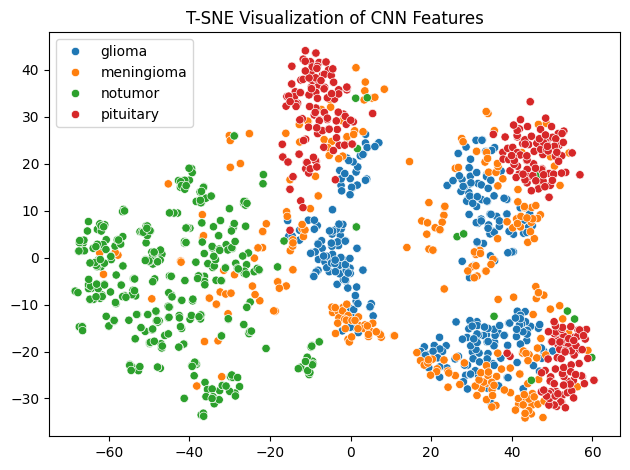

[Error] x_test not available. Ensure data was extracted properly.
——————————————————————————————————————————————————
📊 ResNet50


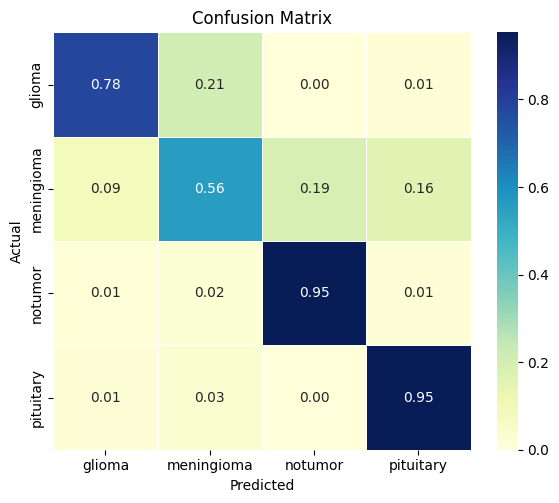

              precision    recall  f1-score   support

      glioma       0.87      0.78      0.82       300
  meningioma       0.68      0.56      0.62       306
     notumor       0.87      0.95      0.91       405
   pituitary       0.83      0.95      0.89       300

    accuracy                           0.82      1311
   macro avg       0.81      0.81      0.81      1311
weighted avg       0.82      0.82      0.82      1311



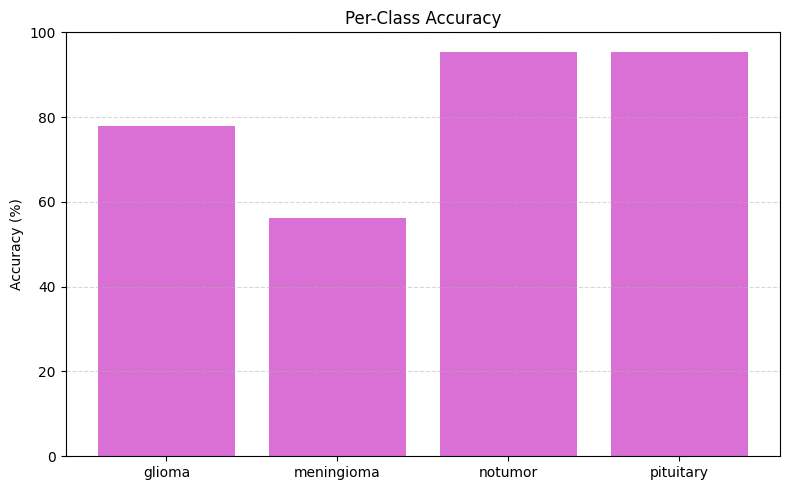

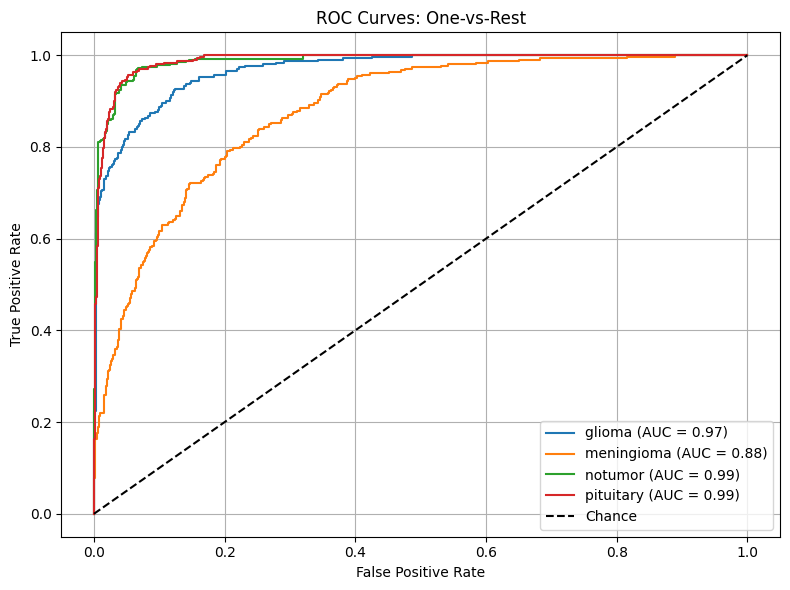

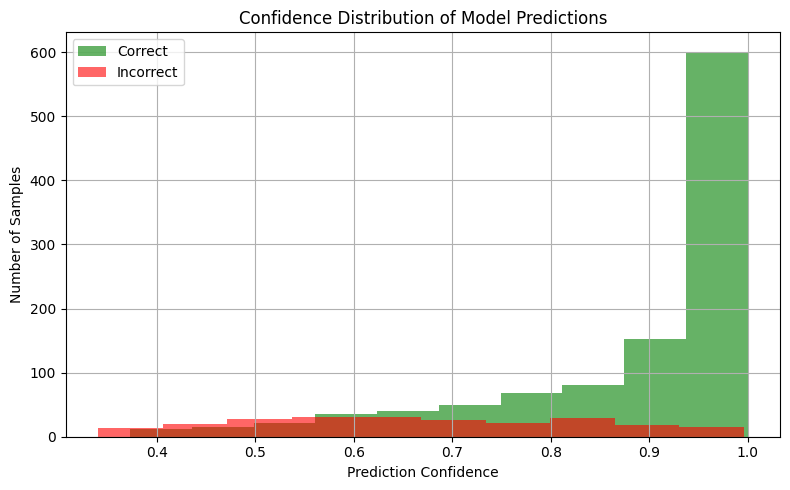

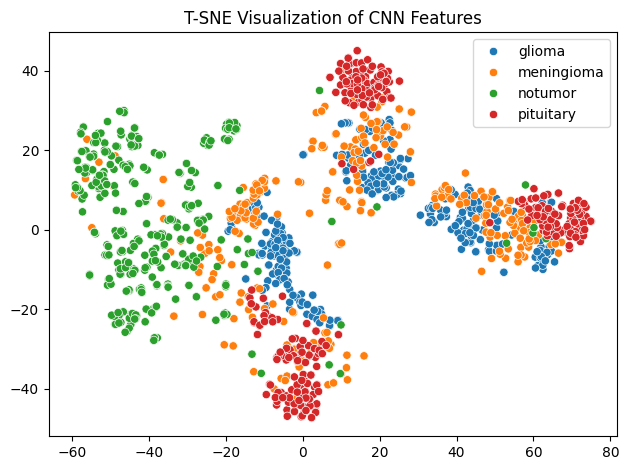

[Error] x_test not available. Ensure data was extracted properly.
——————————————————————————————————————————————————
📊 EfficientNetB0


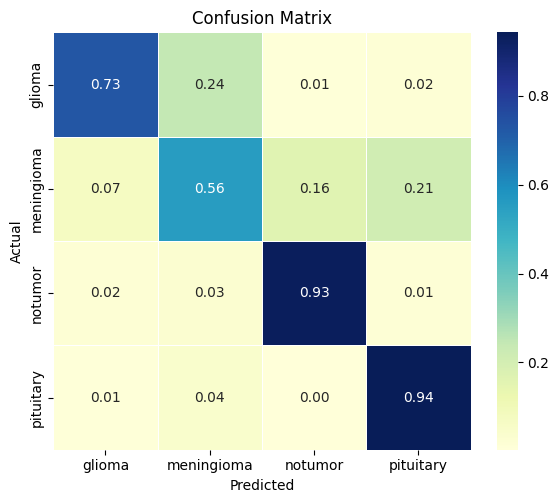

              precision    recall  f1-score   support

      glioma       0.87      0.73      0.79       300
  meningioma       0.63      0.56      0.59       306
     notumor       0.88      0.93      0.90       405
   pituitary       0.79      0.94      0.86       300

    accuracy                           0.80      1311
   macro avg       0.79      0.79      0.79      1311
weighted avg       0.80      0.80      0.80      1311



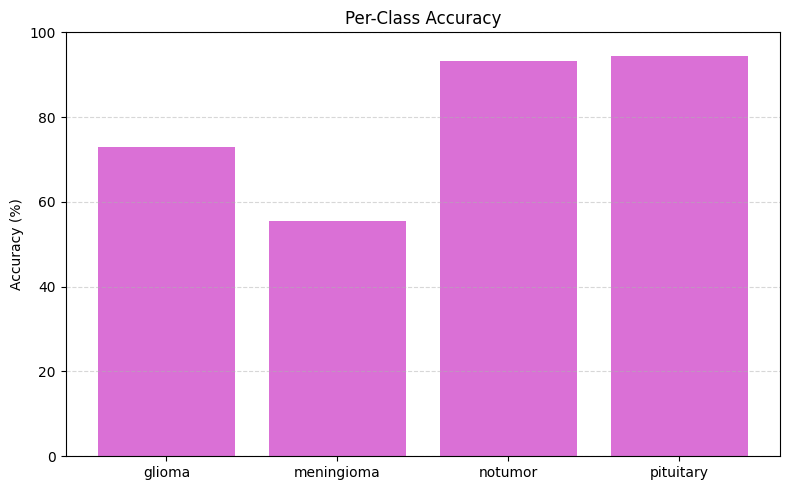

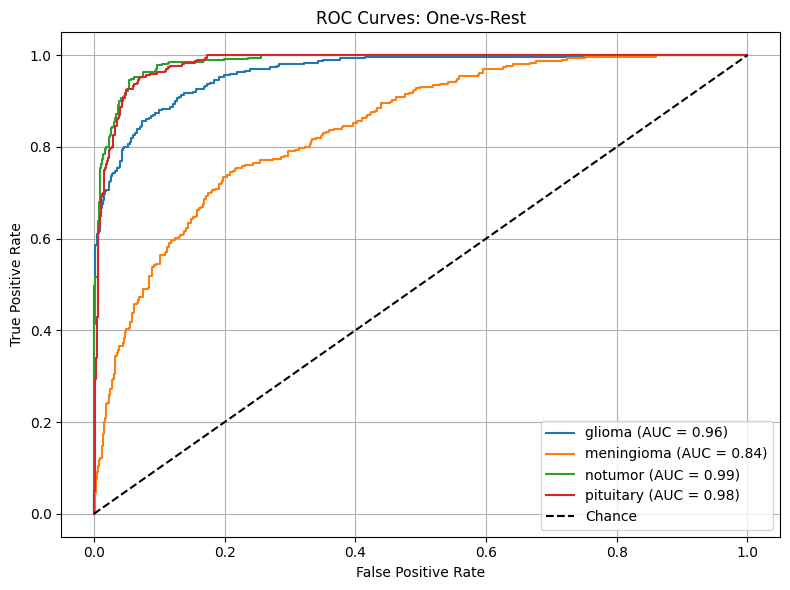

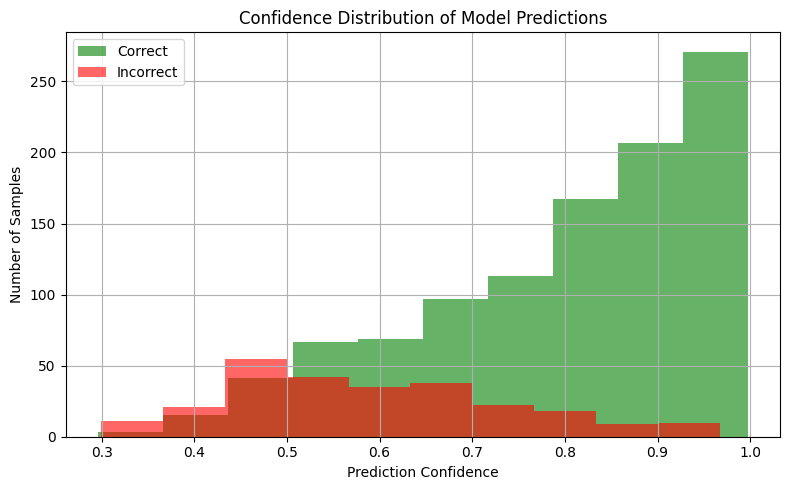

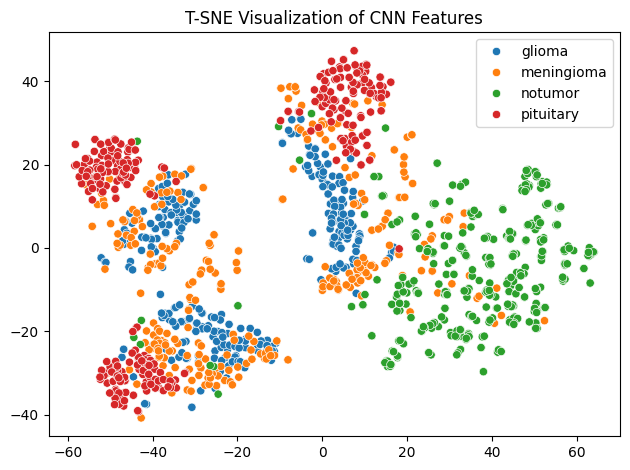

[Error] x_test not available. Ensure data was extracted properly.
——————————————————————————————————————————————————


In [9]:
for name, evaluator in {
    'MobileNetV2': evaluator_mobilenet,
    'ResNet50': evaluator_resnet,
    'EfficientNetB0': evaluator_effnet
}.items():
    print(f"📊 {name}")
    evaluator.plot_confusion_matrix()
    evaluator.show_classification_report()
    evaluator.plot_per_class_accuracy()
    evaluator.plot_roc_curves()
    evaluator.plot_confidence_histogram()
    evaluator.plot_tsne()
    evaluator.show_misclassified_images()
    print("—" * 50)


# **6.) Grad-Cam Images**

In [10]:
for name, evaluator in {
    'MobileNetV2': evaluator_mobilenet,
    'ResNet50': evaluator_resnet,
    'EfficientNetB0': evaluator_effnet
}.items():
    print(f"🔍 Grad-CAM Visualizations – {name}")
    gradcam_samples_by_class(evaluator)


Output hidden; open in https://colab.research.google.com to view.

# **7.) Fine-Tuning MobileNet (augmented data and class weights)**

In [37]:
# 1. Load augmented training data
train_gen_mobile = get_augmented_train_generator(TRAIN_DIR, img_size=(224, 224))

# 2. Load validation generator (non-augmented)
_, val_gen_mobile, _ = create_generators(
    TRAIN_DIR,
    TEST_DIR,
    img_size=(224, 224),
    preprocessing=mobilenet_pre,
    shuffle_test=False
)

# 3. Compute class weights
from sklearn.utils import class_weight
import numpy as np

y_train = train_gen_mobile.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# 4. Load and fine-tune model
fine_tuned_model = finetune_mobilenet_model(
    model_path=f'{BASE_DIR}/saved_models/mobilenet_model.keras',
    fine_tune_at=-10,
    learning_rate=5e-6
)

# 5. Train with class weights and save the model
model, history = train_model(
    model=fine_tuned_model,
    train_gen=train_gen_mobile,
    val_gen=val_gen_mobile,
    test_gen=test_gen_mobile,  # defined earlier
    epochs=10,
    class_weight=class_weight_dict
)

model.save(f'{BASE_DIR}/saved_models/mobilenet_finetuned.keras')



Found 5712 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.5695 - loss: 1.0719 - val_accuracy: 0.7318 - val_loss: 0.7114
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.6384 - loss: 0.8797 - val_accuracy: 0.7257 - val_loss: 0.7351
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.6878 - loss: 0.7791 - val_accuracy: 0.7204 - val_loss: 0.7646
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.7007 - loss: 0.7591 - val_accuracy: 0.7108 - val_loss: 0.7943
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

📊 Final Test Accuracy: 0.8101 | Loss: 0.5508
